In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
from modules_gd.model import VAE
# help(VAE)
from modules_gd.data import MSA_Dataset
# help(MSA_Dataset)

## Inspect the pre-processed MSA

In [2]:
MSA_id = "PF00067"
query_seq_id = "A0A8J5V3X2_ZIZPA/310-424"
outgroup_acc = "A0A010Z6J1_9ACTN/277-406"
data_path = f"data/Ding/processed/{MSA_id}"

In [3]:
!echo Total number of sequences:
! wc -l {data_path}/seq_msa_char.txt 
!echo Check that query sequence present:
! grep {query_seq_id} {data_path}/seq_msa_char.txt 
!echo Check that outgroup sequence present:
! grep {outgroup_acc} {data_path}/seq_msa_char.txt
!echo Print first 25 sequences:
! head -n 25 {data_path}/seq_msa_char.txt 

Total number of sequences:
   30543 data/Ding/processed/PF00067/seq_msa_char.txt
Check that query sequence present:
A0A8J5V3X2_ZIZPA/310-424	RLREEVRRVLGDGGDVGFTAVREMPLARSTVYEVLRMQPPVPLQFGRARRDFVLRSYEVSKGELLCGYQPLAMRDPAVFDRPDEFVPERFLGNNGEKLQYVYWSNG
Check that outgroup sequence present:
A0A010Z6J1_9ACTN/277-406	.............................WIEETLRYDTSTQLLARYVVADVTLHGVTVPAGSQLLVALGSANRDPAVFTAPDSFDLTRGRDELS......KVRFY
Print first 25 sequences:
A0A8C4CNX3_9TELE/41-498	RVHKEIDEVIGPDRPPMMEDRVKMPYTDAVVHEVQRSMDLAPAVPHKVMRDTEFHNYHIPEGTLVLPLISSVLADPQLWKNPNHFDPENFLDDAGHFQKNDAYECY
A0A6D2KQW5_9BRAS/30-513	KILQEIKTNLPRTSDSMQYYLNKLVYLRGALYEAMRLYPPVPERMSPI.NPDKLPSHKVDASMKILIFIYALGRMEAVWEDALEFKPERWVSKTGIEEPSYKRMKH
A0A8K0MXP5_COCNU/37-492	KAQEEIRASLGTKGKVEEEDLHQLQYLKSVVKETWRLHSPAPLLPRESVRHSRIHGYDILPNTRVYVNAWGIAKDPKSWDDPEEFIPERFMDGPIDYGHNFELHLV
A0A6P5YD73_DURZI/55-522	KVKKELTDVVGLDRTVEEFHLPNLRYLNAVIKETFRLHPALPLVPRCSGKSITVGGYTIPKGSRVFLNIWSIHRDPHIWDNPLQFQPDRFLNDPDDYGSDFRLLI.
A0A0D3FSJ4_9ORYZ/51-514	KAVDELDM

## Load data and instantiate dataset

In [4]:
## read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([30543, 106, 21])

In [5]:
## each sequence has a label
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
seq_names[:10]

['A0A8C4CNX3_9TELE/41-498',
 'A0A6D2KQW5_9BRAS/30-513',
 'A0A8K0MXP5_COCNU/37-492',
 'A0A6P5YD73_DURZI/55-522',
 'A0A0D3FSJ4_9ORYZ/51-514',
 'A0A2V1DIY2_9PLEO/30-468',
 'A0A8J6AVG1_GALPY/899-1088',
 'A0A168DGB0_CORFA/1-418',
 'A0A8H6P498_9EURO/256-505',
 'A0A7J6X3X1_THATH/28-493']

In [6]:
## sequences in msa are weighted
with open(f"{data_path}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
print(np.sum(seq_weight))

1.0


In [7]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random sample
data[100]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]),
 2.9117298e-05,
 'A0A6P5RPV8_PRUAV/34-497')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [8]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [9]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[ 0.0410, -0.0242]], grad_fn=<AddmmBackward0>), tensor([[1.0253, 0.9453]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 106, 21]) and is given by:
tensor([[[-3.0725, -3.0931, -2.9972,  ..., -3.0029, -3.0873, -2.9570],
         [-3.0633, -3.1086, -2.9777,  ..., -2.9520, -2.9612, -3.1226],
         [-3.0269, -3.0363, -2.9626,  ..., -3.2777, -3.0591, -3.0219],
         ...,
         [-3.0581, -2.9681, -3.0152,  ..., -3.2542, -2.9383, -3.1771],
         [-3.1211, -2.9916, -3.0708,  ..., -2.9517, -2.9873, -3.0647],
         [-2.9801, -2.9458, -3.1388,  ..., -2.9687, -3.0858, -3.0782]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0463, 0.0454, 0.0499,  ..., 0.0496, 0.0456, 0.0520],
        [0.0467, 0.0447, 0.0509,  ..., 0.0522, 0.0518, 0.0440],
        [0.0485, 0.0480, 0.0517,  ..., 0.0377, 0.0469, 0.0487],
        ...,
        [0.0470, 0.0514, 0.0490,  ..., 0.0386,

## Train model

In [10]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size = 0.1)
train_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(train_idx))
test_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(test_idx))

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 30
weight_decay = 0.01
dim_lat = 2
batch_size = 32
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100)
      elbo_scalar = torch.sum(elbo).data.item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, sigma = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



cpu


In [13]:
train_losses = []
test_elbos = []
test_recon_accs = []

# Instantiate a new model for this fold
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, test_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
  epoch_train_loss = np.mean(batch_losses)
  train_losses.append(epoch_train_loss)
  print(f"Training loss for epoch {epoch}: {epoch_train_loss}")
  

Test elbo for epoch 0: -10274.55984909687
Test reconstruction accuracy for fold epoch 0: 0.05175515109052261
Training loss for epoch 0: 217.91080353174
Test elbo for epoch 1: -6409.955412642822
Test reconstruction accuracy for fold epoch 1: 0.4176575591166814
Training loss for epoch 1: 207.32598002992214
Test elbo for epoch 2: -6107.987938624877
Test reconstruction accuracy for fold epoch 2: 0.45045593349883956
Training loss for epoch 2: 198.53355635086788
Test elbo for epoch 3: -5858.545646748505
Test reconstruction accuracy for fold epoch 3: 0.47286097984761
Training loss for epoch 3: 192.86980062535812
Test elbo for epoch 4: -5726.656280840689
Test reconstruction accuracy for fold epoch 4: 0.48567380880316097
Training loss for epoch 4: 189.40489395727795
Test elbo for epoch 5: -5625.601190445525
Test reconstruction accuracy for fold epoch 5: 0.4953307236234347
Training loss for epoch 5: 186.98302259878173
Test elbo for epoch 6: -5573.909990222789
Test reconstruction accuracy for fol

In [17]:
# Save model
from datetime import date
model.cpu()
today = date.today()
torch.save(model.state_dict(), f"saved_models/{MSA_id}/model_{today}.pt")

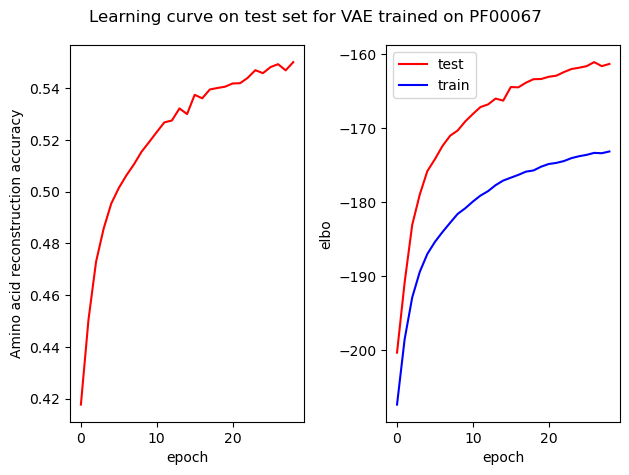

In [16]:
# plot learning curve
fig, axs = plt.subplots(1, 2)

axs[0].plot(test_recon_accs[1:], color = 'r')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel(f"Amino acid reconstruction accuracy")

axs[1].plot([x/batch_size for x in test_elbos[1:]], label = "test", color = 'r')
axs[1].plot([-x for x in train_losses[1:]], label = "train", color = 'b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel(f"elbo")
axs[1].legend()

# add title
plt.suptitle(f"Learning curve on test set for VAE trained on {MSA_id}")
plt.tight_layout()
